In [1]:
import gc

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

xgb.__version__

sns.set_palette("Paired")

In [2]:
# Read attribute file to see the context

pd.read_csv('attributes.csv')

,Attributes,Details
0,user_id,user id (unique per buyer)
1,product_id,product id (unique per product purchased)
2,gender,gender of the user
3,bmi,users basal metabolic rate
4,age,age of the user
5,occupation,user’s occupation
6,city_category,city user lives in
7,stay_in_current_city_years,current stayed time in the city
8,marital_status,users marital status
9,product_category_1,product category attribute


### In this section I read the json files seperately and converted them to data frames. Then I have merged all the tables to get the data frame for exploration and then building machine learning models. 

In [ ]:
df_products = pd.read_json('products.json', orient='index')
df_products.head()

In [4]:
df_products.reset_index(inplace=True)

df_products.rename(columns={'index': 'product_id'}, inplace=True)
df_products

,product_id,product_category_1,product_category_2,product_category_3
0,P00069042,3,,
1,P00248942,1,6.0,14.0
2,P00087842,12,,
3,P00085442,12,14.0,
4,P00285442,8,,
...,...,...,...,...
3626,P00375436,20,,
3627,P00372445,20,,
3628,P00370293,19,,
3629,P00371644,20,,


In [5]:
df_users = pd.read_json('users.json', orient='index')
df_users.head()

,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years
1000001,0-17,1858,A,F,0,10,2
1000002,55+,1775,C,M,0,16,4+
1000003,26-35,2357,A,M,0,15,3
1000004,46-50,2529,B,M,1,7,2
1000005,26-35,2946,A,M,1,20,1


In [6]:
df_users.reset_index(inplace=True)

df_users.rename(columns={'index': 'user_id'}, inplace=True)
df_users

,user_id,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years
0,1000001,0-17,1858,A,F,0,10,2
1,1000002,55+,1775,C,M,0,16,4+
2,1000003,26-35,2357,A,M,0,15,3
3,1000004,46-50,2529,B,M,1,7,2
4,1000005,26-35,2946,A,M,1,20,1
...,...,...,...,...,...,...,...,...
5886,1004588,26-35,2103,C,F,0,4,0
5887,1004871,18-25,1237,C,M,0,12,2
5888,1004113,36-45,2086,C,M,0,17,3
5889,1005391,26-35,1726,A,M,0,7,0


In [7]:
df_purchases = pd.read_json('purchases.json', orient='index')
df_purchases.head()

,1000001,1000002,1000003,1000004,1000005,1000006,1000007,1000008,1000009,1000010,...,1006031,1006032,1006033,1006034,1006035,1006036,1006037,1006038,1006039,1006040
products_purchased ($),"{'P00069042': 8370.0, 'P00248942': 15200.0, 'P...","{'P00285442': 7969.0, 'P00112842': 6187.0, 'P0...","{'P00193542': 15227.0, 'P00132842': 12103.0, '...","{'P00184942': 19215.0, 'P00346142': 15854.0, '...","{'P00274942': 7871.0, 'P00251242': 5254.0, 'P0...","{'P00231342': 5378.0, 'P00190242': 2079.0, 'P0...","{'P00036842': 11788.0, 'P00046742': 15447.0, '...","{'P00249542': 19614.0, 'P00220442': 8584.0, 'P...","{'P00135742': 16662.0, 'P00039942': 5887.0, 'P...","{'P00085942': 16352.0, 'P00118742': 8886.0, 'P...",...,"{'P00260042': 5405.0, 'P00321742': 1944.0, 'P0...","{'P00327642': 2395.0, 'P00118542': 8603.0, 'P0...","{'P00178042': 7821.0, 'P00044442': 19322.0, 'P...","{'P00252242': 20317.0, 'P00116942': 20258.0, '...","{'P00237542': 19402.0, 'P00221642': 5263.0, 'P...","{'P00237642': 3759.0, 'P00250342': 8593.0, 'P0...","{'P00067342': 4258.0, 'P00111842': 10081.0, 'P...","{'P00034742': 6878.0, 'P00251242': 5382.0, 'P0...","{'P00114042': 5413.0, 'P00199442': 5461.0, 'P0...","{'P00184042': 19153.0, 'P00158742': 3603.0, 'P..."


In [8]:
# Convert the first row into a dictionary of dictionaries
# with each user ID as a key and corresponding dictionary as purchase
purchases = df_purchases.T['products_purchased ($)'].apply(lambda x: x.items())

# Expand each user's records into separate rows
df_purchases = purchases.explode().apply(pd.Series)

# Rename the resulting columns to meaningful names
df_purchases.columns = ['product_id', 'purchase']

# Reset the index to make `user_id` a column
df_purchases.reset_index(inplace=True)

# Rename the index column to `user_id`
df_purchases.rename(columns={'index': 'user_id'}, inplace=True)

# Change 'user_id' dtype
df_purchases['user_id'] = df_purchases['user_id'].astype(object)

df_purchases.head()

,user_id,product_id,purchase
0,1000001,P00069042,8370.0
1,1000001,P00248942,15200.0
2,1000001,P00087842,1422.0
3,1000001,P00085442,1057.0
4,1000001,P00085942,12842.0


In [9]:
# Merge users with purchases on user_id
df = df_purchases.merge(df_users, on='user_id')

# Merge the result with products on product_id
df = df.merge(df_products, on='product_id')

df.head()

,user_id,product_id,purchase,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,product_category_1,product_category_2,product_category_3
0,1000001,P00069042,8370.0,0-17,1858,A,F,0,10,2,3,,
1,1000017,P00069042,13591.0,51-55,2932,C,M,0,1,0,3,,
2,1000023,P00069042,11022.0,36-45,2555,B,M,1,0,3,3,,
3,1000030,P00069042,8036.0,36-45,1196,C,F,0,7,3,3,,
4,1000073,P00069042,10885.0,18-25,1370,A,M,0,4,4+,3,,


In [10]:
# Since we are done with the users, products and purchases table, we can delete them to release the memory
del df_purchases
del df_users
del df_products
gc.collect()

0

### Check the dataset for general information.

In [14]:
df.isnull().sum() # It shows there is no missing value in the data, but later we will see there is "" in product_category_2 and product_category_3

user_id                       0
product_id                    0
purchase                      0
age                           0
bmr                           0
city_category                 0
gender                        0
marital_status                0
occupation                    0
stay_in_current_city_years    0
product_category_1            0
product_category_2            0
product_category_3            0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550068 entries, 0 to 550067
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     550068 non-null  object 
 1   product_id                  550068 non-null  object 
 2   purchase                    550068 non-null  float64
 3   age                         550068 non-null  object 
 4   bmr                         550068 non-null  int64  
 5   city_category               550068 non-null  object 
 6   gender                      550068 non-null  object 
 7   marital_status              550068 non-null  int64  
 8   occupation                  550068 non-null  int64  
 9   stay_in_current_city_years  550068 non-null  object 
 10  product_category_1          550068 non-null  int64  
 11  product_category_2          550068 non-null  object 
 12  product_category_3          550068 non-null  object 
dtypes: float64(1),

In [17]:
df.describe()

,purchase,bmr,marital_status,occupation,product_category_1
count,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,9263.968713,2044.503485,0.409653,8.076707,5.404270
std,5023.065394,522.457746,0.491770,6.522660,3.936211
min,12.000000,1150.000000,0.000000,0.000000,1.000000
25%,5823.000000,1598.000000,0.000000,2.000000,1.000000
50%,8047.000000,2054.000000,0.000000,7.000000,5.000000
75%,12054.000000,2504.000000,1.000000,14.000000,8.000000
max,23961.000000,2949.000000,1.000000,20.000000,20.000000


In [18]:
df.duplicated().sum() # There is no duplicates in the dataset.

0

In [19]:
df.columns

Index(['user_id', 'product_id', 'purchase', 'age', 'bmr', 'city_category',
       'gender', 'marital_status', 'occupation', 'stay_in_current_city_years',
       'product_category_1', 'product_category_2', 'product_category_3'],
      dtype='object')

In [122]:
df['user_id'].nunique()

5891

In [123]:
df['product_id'].nunique()

3631

### In this section, I look at the columns one by one

### Purchase Column

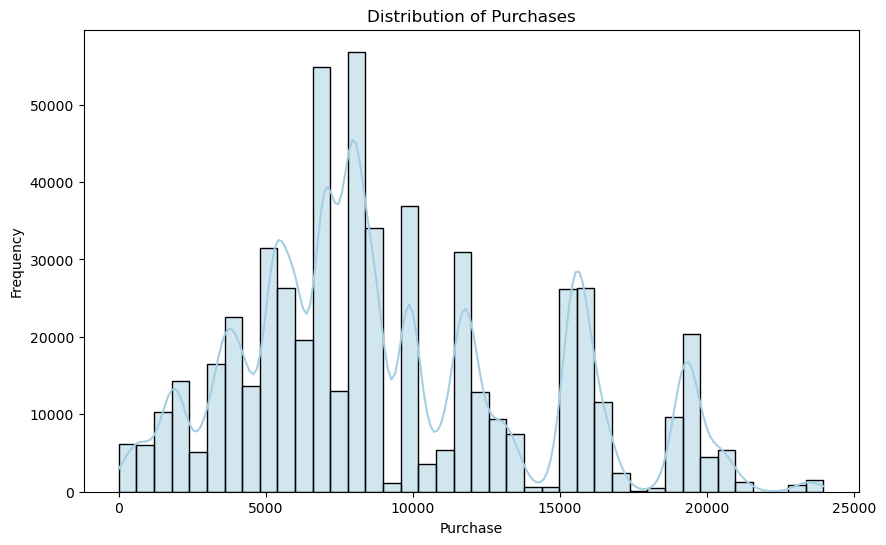

In [114]:
# Distribution of Purchase purchases
plt.figure(figsize=(10, 6))
sns.histplot(df['purchase'], bins=40, kde=True)
plt.title('Distribution of Purchases')
plt.xlabel('Purchase')
plt.ylabel('Frequency')
plt.show()

### The presence of multiple peaks in this distribution can suggest different groups or types of purchases within the dataset. For example, smaller peaks around 5,000 and 15,000 might indicate typical amounts spent on different categories of products 

<Axes: ylabel='purchase'>

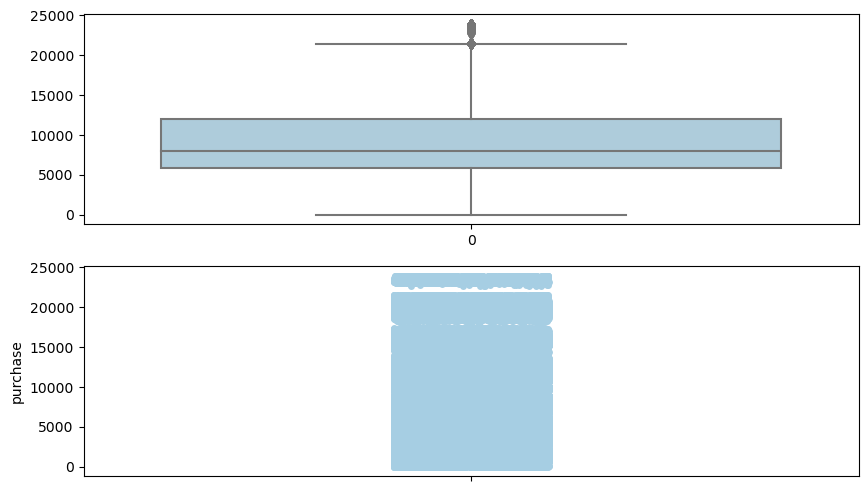

In [22]:
plt.figure(figsize=(10, 6))

plt.subplot(211)
sns.boxplot(df['purchase'])

plt.subplot(212)
sns.stripplot(df['purchase'])

### The boxplot reveals the central tendency and variability of purchase values, highlighting the median and detecting outliers, notably a few higher purchase values that stand out. Simultaneously, the stripplot complements this by visually representing each individual purchase, emphasizing the concentration of lower-value transactions and providing insight into the density and distribution across different spending amounts. 

### Age Column

In [23]:
df['age'].value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: age, dtype: int64

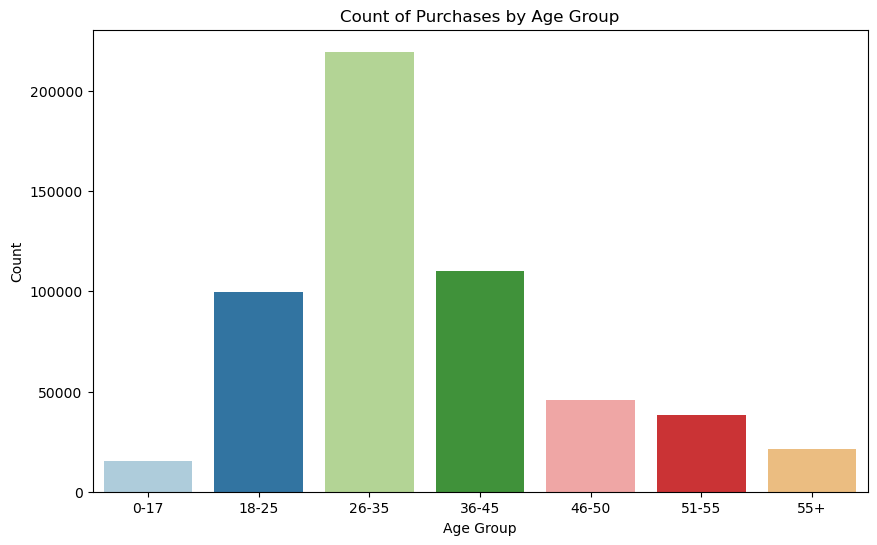

In [24]:
# Count of Purchases by Age Group
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age', order=sorted(df['age'].unique()))
plt.title('Count of Purchases by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

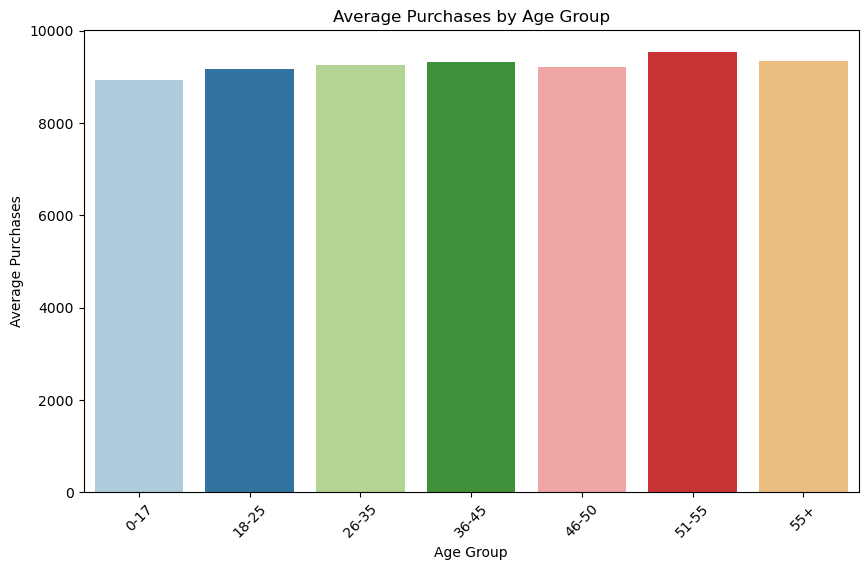

In [27]:
# Group the data by age and average the purchase
age_purchases = df.groupby('age')['purchase'].mean()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=age_purchases.index, y=age_purchases.values)
plt.title('Average Purchases by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Purchases')
plt.xticks(rotation=45)  
plt.show()


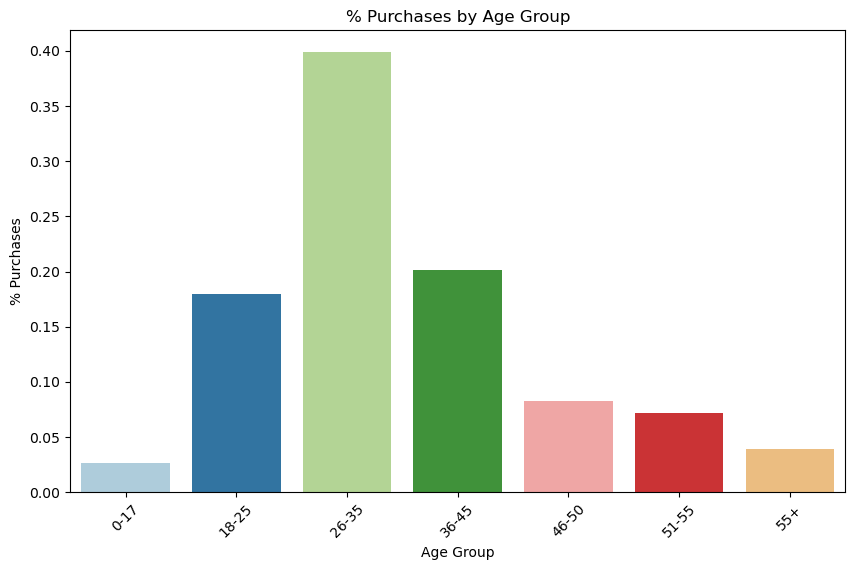

In [28]:
# Group the data by age and calculate percentage of the purchase 
age_percentage = df.groupby('age')['purchase'].sum()/df['purchase'].sum()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=age_percentage.index, y=age_percentage.values)
plt.title('% Purchases by Age Group')
plt.xlabel('Age Group')
plt.ylabel('% Purchases')
plt.xticks(rotation=45) 
plt.show()

### Most of the purchases are made by the age group 26-35 and there is not much difference in avarage purchases in different age groups. 

In [29]:
age_mapping = {'0-17':1,'18-25':2,'26-35':3,'36-45':4,'46-50':5,'51-55':6,'55+':7}

df['age_int'] = df['age'].map(age_mapping)

df.head()

,user_id,product_id,purchase,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,product_category_1,product_category_2,product_category_3,age_int
0,1000001,P00069042,8370.0,0-17,1858,A,F,0,10,2,3,,,1
1,1000017,P00069042,13591.0,51-55,2932,C,M,0,1,0,3,,,6
2,1000023,P00069042,11022.0,36-45,2555,B,M,1,0,3,3,,,4
3,1000030,P00069042,8036.0,36-45,1196,C,F,0,7,3,3,,,4
4,1000073,P00069042,10885.0,18-25,1370,A,M,0,4,4+,3,,,2


### City Category Column

In [30]:
df['city_category'].value_counts()

B    231173
C    171175
A    147720
Name: city_category, dtype: int64

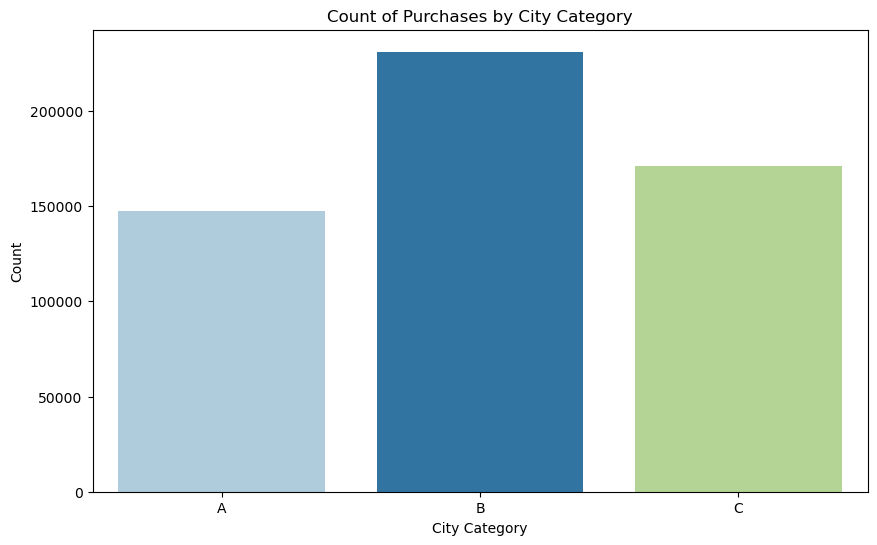

In [31]:
# Count of Purchases by City Group
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='city_category', order=sorted(df['city_category'].unique()))
plt.title('Count of Purchases by City Category')
plt.xlabel('City Category')
plt.ylabel('Count')
plt.show()

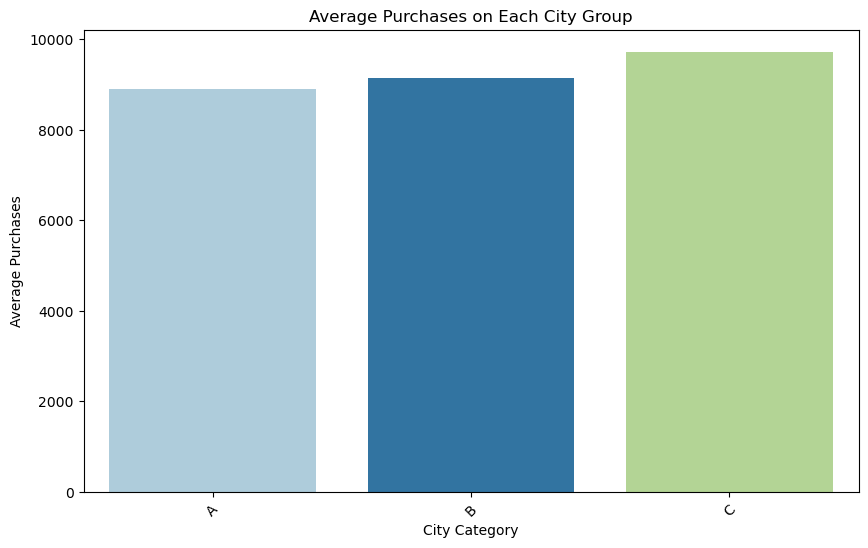

In [32]:
# Group the data by city_category and average purchases
city_purchases = df.groupby('city_category')['purchase'].mean()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=city_purchases.index, y=city_purchases.values)
plt.title('Average Purchases on Each City Group')
plt.xlabel('City Category')
plt.ylabel('Average Purchases')
plt.xticks(rotation=45)  
plt.show()

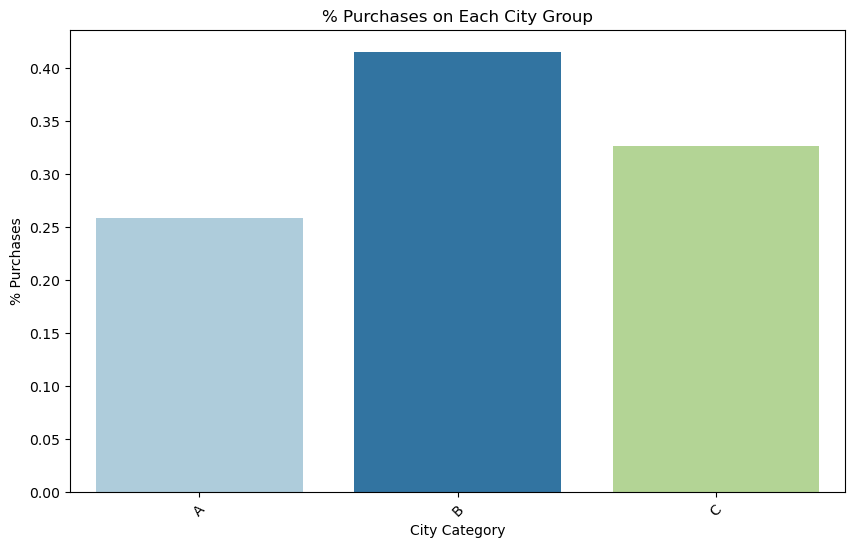

In [33]:
# Group the data by city_category and calculate percentage of the purchases
perc_city_purchases = df.groupby('city_category')['purchase'].sum()/df['purchase'].sum()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=perc_city_purchases.index, y=perc_city_purchases.values)
plt.title('% Purchases on Each City Group')
plt.xlabel('City Category')
plt.ylabel('% Purchases')
plt.xticks(rotation=45) 
plt.show()

### Most of the purchases are made in City B. There is no diffence in purchases in different cities. 

In [34]:
df_city_dummies = pd.get_dummies(df['city_category'], prefix='city_category').astype(int)
df_city_dummies.head()

,city_category_A,city_category_B,city_category_C
0,1,0,0
1,0,0,1
2,0,1,0
3,0,0,1
4,1,0,0


In [35]:
df = pd.concat([df, df_city_dummies], axis=1)
df.head()

,user_id,product_id,purchase,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,product_category_1,product_category_2,product_category_3,age_int,city_category_A,city_category_B,city_category_C
0,1000001,P00069042,8370.0,0-17,1858,A,F,0,10,2,3,,,1,1,0,0
1,1000017,P00069042,13591.0,51-55,2932,C,M,0,1,0,3,,,6,0,0,1
2,1000023,P00069042,11022.0,36-45,2555,B,M,1,0,3,3,,,4,0,1,0
3,1000030,P00069042,8036.0,36-45,1196,C,F,0,7,3,3,,,4,0,0,1
4,1000073,P00069042,10885.0,18-25,1370,A,M,0,4,4+,3,,,2,1,0,0


### Gender Column

In [36]:
df['gender'].value_counts()

M    414259
F    135809
Name: gender, dtype: int64

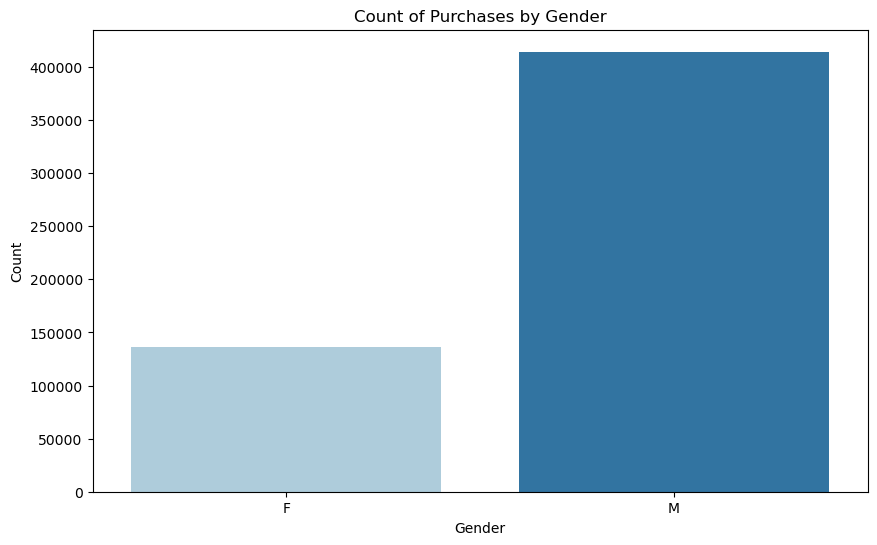

In [37]:
# Count of Purchases by Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='gender', order=sorted(df['gender'].unique()))
plt.title('Count of Purchases by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

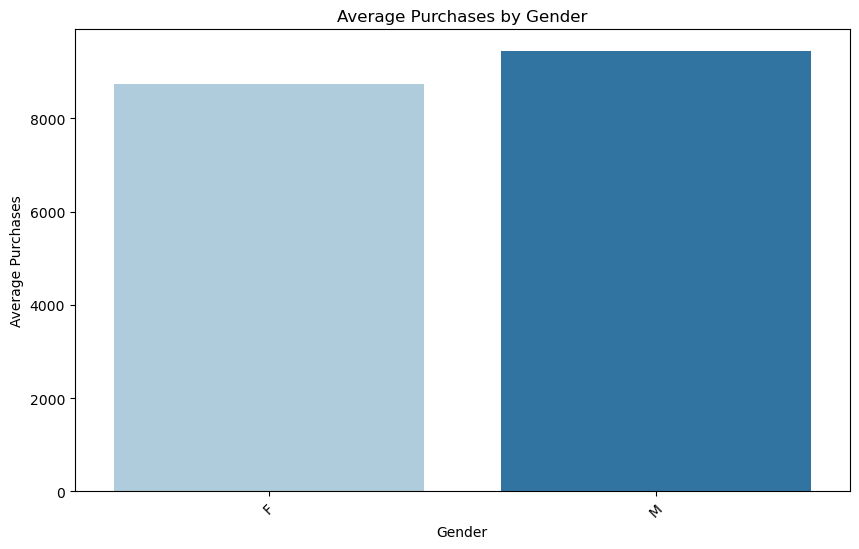

In [38]:
# Group the data by gender and average the purchase
gender_purchases = df.groupby('gender')['purchase'].mean()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=gender_purchases.index, y=gender_purchases.values)
plt.title('Average Purchases by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Purchases')
plt.xticks(rotation=45) 
plt.show()

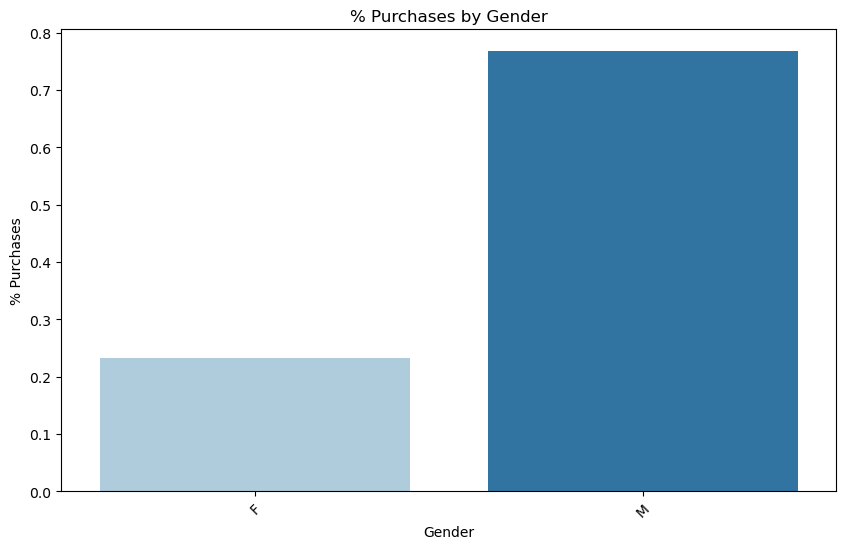

In [39]:
# Group the data by gender and calculate percentage of purchases
perc_gender_purchases = df.groupby('gender')['purchase'].sum()/df['purchase'].sum()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=perc_gender_purchases.index, y=perc_gender_purchases.values)
plt.title('% Purchases by Gender')
plt.xlabel('Gender')
plt.ylabel('% Purchases')
plt.xticks(rotation=45) 
plt.show()

### Most of the purchases made by Gender and there is no difference between average purchases

In [40]:
df_gender_dummies = pd.get_dummies(df['gender'], prefix='gender').astype(int)
df_gender_dummies.head()

,gender_F,gender_M
0,1,0
1,0,1
2,0,1
3,1,0
4,0,1


In [41]:
df = pd.concat([df, df_gender_dummies], axis=1)
df.head()

,user_id,product_id,purchase,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,product_category_1,product_category_2,product_category_3,age_int,city_category_A,city_category_B,city_category_C,gender_F,gender_M
0,1000001,P00069042,8370.0,0-17,1858,A,F,0,10,2,3,,,1,1,0,0,1,0
1,1000017,P00069042,13591.0,51-55,2932,C,M,0,1,0,3,,,6,0,0,1,0,1
2,1000023,P00069042,11022.0,36-45,2555,B,M,1,0,3,3,,,4,0,1,0,0,1
3,1000030,P00069042,8036.0,36-45,1196,C,F,0,7,3,3,,,4,0,0,1,1,0
4,1000073,P00069042,10885.0,18-25,1370,A,M,0,4,4+,3,,,2,1,0,0,0,1


### Marital Status Column

In [42]:
df['marital_status'].value_counts()

0    324731
1    225337
Name: marital_status, dtype: int64

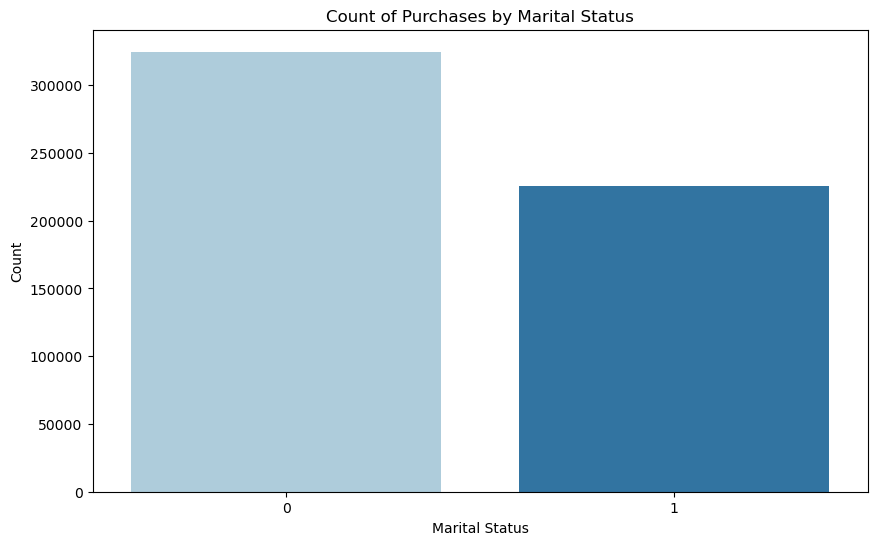

In [43]:
# Count of Purchases by Marital Status
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='marital_status', order=sorted(df['marital_status'].unique()))
plt.title('Count of Purchases by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.show()

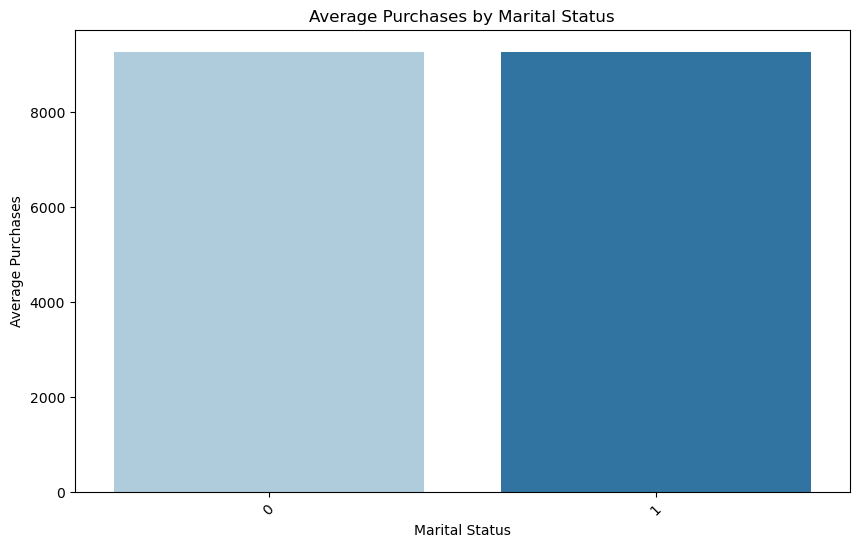

In [44]:
# Group the data by Marital Status and average purchases
marital_status_purchases = df.groupby('marital_status')['purchase'].mean()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=marital_status_purchases.index, y=marital_status_purchases.values)
plt.title('Average Purchases by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Average Purchases')
plt.xticks(rotation=45) 
plt.show()

### Above graphs tells us that unmarried are made more purchases than married people.

### Occupation Column

In [45]:
df['occupation'].value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: occupation, dtype: int64

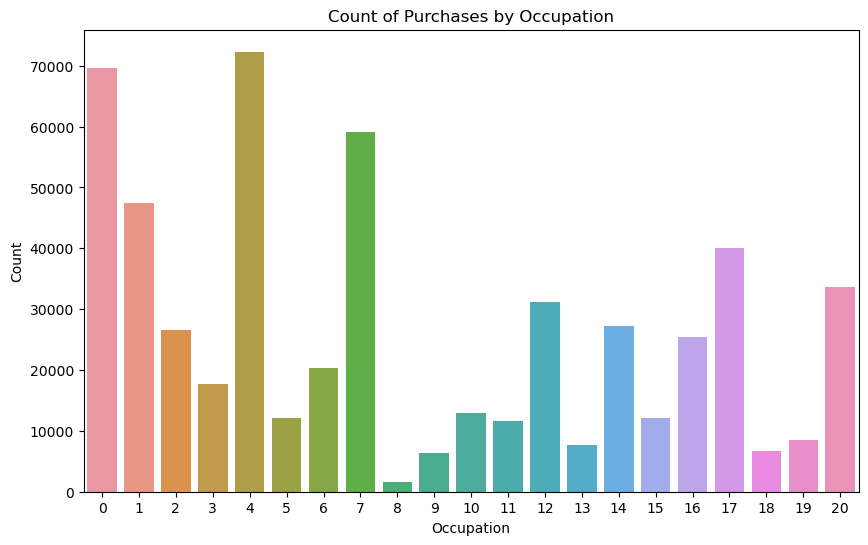

In [46]:
# Count of Purchases by Occupation
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='occupation', order=sorted(df['occupation'].unique()))
plt.title('Count of Purchases by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.show()

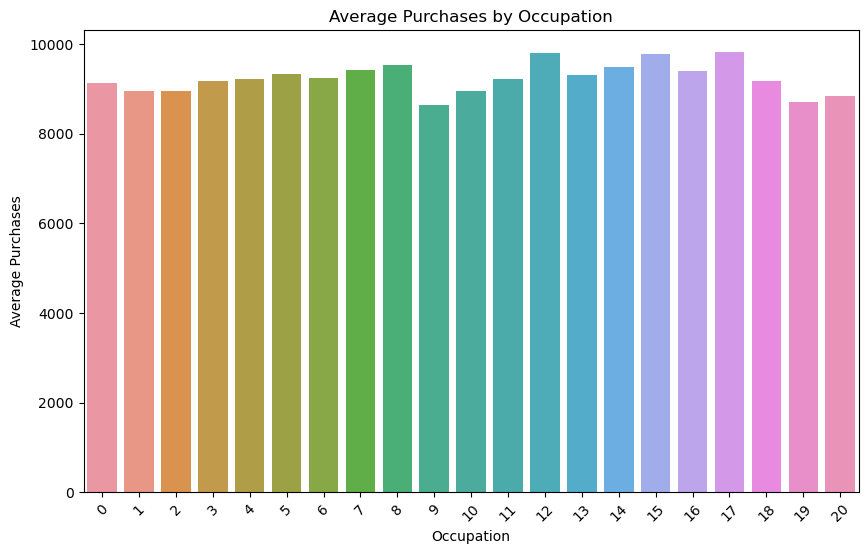

In [47]:
# Group the data by Occupation and average purchases
occupation_purchases = df.groupby('occupation')['purchase'].mean()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=occupation_purchases.index, y=occupation_purchases.values)
plt.title('Average Purchases by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Purchases')
plt.xticks(rotation=45)
plt.show()

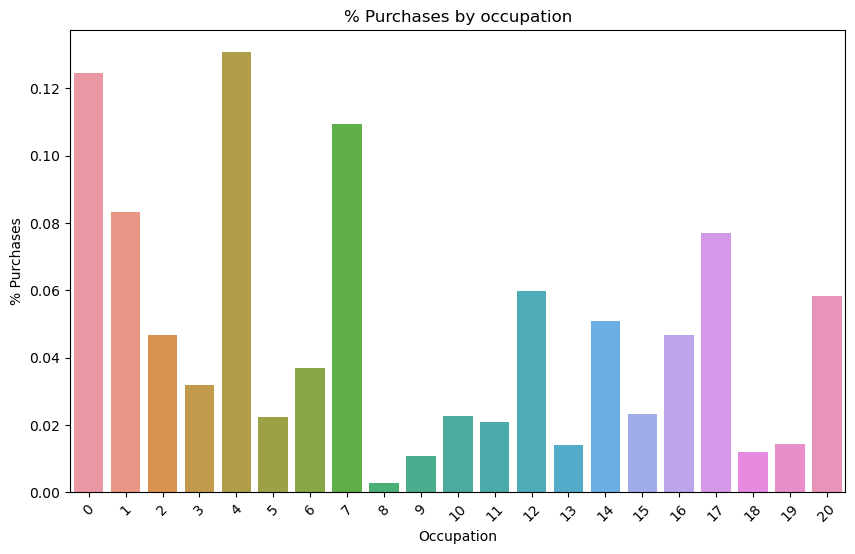

In [49]:
# Group the data by occupation and calculate percentage of the purchase 
occ_purchases = df.groupby('occupation')['purchase'].sum()/df['purchase'].sum()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=occ_purchases.index, y=occ_purchases.values)
plt.title('% Purchases by occupation')
plt.xlabel('Occupation')
plt.ylabel('% Purchases')
plt.xticks(rotation=45)  
plt.show()

### Above graphs shows that the people with different occupation have different purchase behavior in number of purchases but not in average purchase value. 

In [50]:
df_occupation_dummies = pd.get_dummies(df['occupation'], prefix='occupation').astype(int)
df_occupation_dummies.head()

,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,...,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df = pd.concat([df, df_occupation_dummies], axis=1)
df.head()

,user_id,product_id,purchase,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,...,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20
0,1000001,P00069042,8370.0,0-17,1858,A,F,0,10,2,...,0,0,0,0,0,0,0,0,0,0
1,1000017,P00069042,13591.0,51-55,2932,C,M,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1000023,P00069042,11022.0,36-45,2555,B,M,1,0,3,...,0,0,0,0,0,0,0,0,0,0
3,1000030,P00069042,8036.0,36-45,1196,C,F,0,7,3,...,0,0,0,0,0,0,0,0,0,0
4,1000073,P00069042,10885.0,18-25,1370,A,M,0,4,4+,...,0,0,0,0,0,0,0,0,0,0


### Stay in Current City Years Column

In [52]:
df['stay_in_current_city_years'].value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: stay_in_current_city_years, dtype: int64

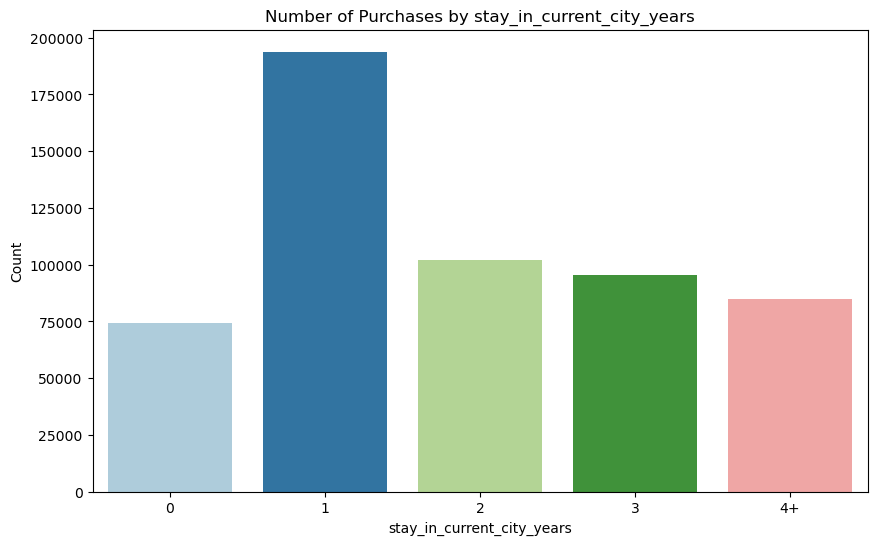

In [116]:
# Count of Purchases by stay_in_current_city_years
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='stay_in_current_city_years', order=sorted(df['stay_in_current_city_years'].unique()))
plt.title('Number of Purchases by stay_in_current_city_years')
plt.xlabel('stay_in_current_city_years')
plt.ylabel('Count')
plt.show()

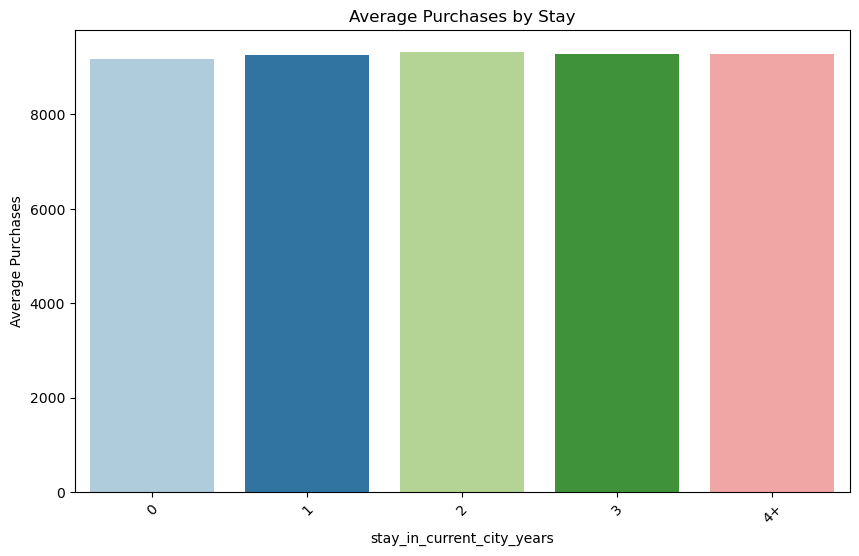

In [117]:
# Group the data by Stay and average purchases
stay_purchases = df.groupby('stay_in_current_city_years')['purchase'].mean()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=stay_purchases.index, y=stay_purchases.values)
plt.title('Average Purchases by Stay')
plt.xlabel('stay_in_current_city_years')
plt.ylabel('Average Purchases')
plt.xticks(rotation=45)
plt.show()

#### Most of the purchases made by people who lives there for 1 year and all the groups almost have identical average purchase value. 

In [54]:
df['stay_in_current_city_years_int'] = df['stay_in_current_city_years'].str.replace('4\+', '4', regex=True).astype(int)

In [55]:
df.head()

,user_id,product_id,purchase,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,...,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20,stay_in_current_city_years_int
0,1000001,P00069042,8370.0,0-17,1858,A,F,0,10,2,...,0,0,0,0,0,0,0,0,0,2
1,1000017,P00069042,13591.0,51-55,2932,C,M,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1000023,P00069042,11022.0,36-45,2555,B,M,1,0,3,...,0,0,0,0,0,0,0,0,0,3
3,1000030,P00069042,8036.0,36-45,1196,C,F,0,7,3,...,0,0,0,0,0,0,0,0,0,3
4,1000073,P00069042,10885.0,18-25,1370,A,M,0,4,4+,...,0,0,0,0,0,0,0,0,0,4


### Product Category_1 Column

In [119]:
df['product_category_1'].nunique() # There are 20 different products in category_1

20

In [56]:
df['product_category_1'].value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: product_category_1, dtype: int64

In [57]:
df['product_category_1'] = df['product_category_1'].astype(str) # changing the data type from int to str

### Product Category_2 Column

In [58]:
df['product_category_2'].value_counts()

        173638
8.0      64088
14.0     55108
2.0      49217
16.0     43255
15.0     37855
5.0      26235
4.0      25677
6.0      16466
11.0     14134
17.0     13320
13.0     10531
9.0       5693
12.0      5528
10.0      3043
3.0       2884
18.0      2770
7.0        626
Name: product_category_2, dtype: int64

In [59]:
product_category_2_mask = df['product_category_2']=="" # selecting blank row to replace them with NAN
product_category_2_mask

0          True
1          True
2          True
3          True
4          True
          ...  
550063     True
550064     True
550065    False
550066     True
550067     True
Name: product_category_2, Length: 550068, dtype: bool

In [60]:
df.loc[~product_category_2_mask,'product_category_2'] = pd.to_numeric(df.loc[~product_category_2_mask,'product_category_2']).astype(int).astype(str)

In [61]:
df.loc[product_category_2_mask,'product_category_2'] = np.nan

### Product Category_3 Column

In [62]:
df['product_category_3'].value_counts()

        383247
16.0     32636
15.0     28013
14.0     18428
17.0     16702
5.0      16658
8.0      12562
9.0      11579
12.0      9246
13.0      5459
6.0       4890
18.0      4629
4.0       1875
11.0      1805
10.0      1726
3.0        613
Name: product_category_3, dtype: int64

In [63]:
product_category_3_mask = df['product_category_3']== ""  # selecting blank row to replace them with NAN
product_category_3_mask

0          True
1          True
2          True
3          True
4          True
          ...  
550063     True
550064     True
550065    False
550066     True
550067     True
Name: product_category_3, Length: 550068, dtype: bool

In [64]:
df.loc[~product_category_3_mask,'product_category_3'] = pd.to_numeric(df.loc[~product_category_3_mask,'product_category_3']).astype(int).astype(str)

In [65]:
df.loc[product_category_3_mask,'product_category_3'] = np.nan

In [66]:
# Converting product_category_1, product_category_2, product_category_3 into a column of lists

df['product_category_list'] = df.apply(lambda row: [x for x in row[['product_category_1', 'product_category_2','product_category_3']] if pd.notna(x)], axis=1)

In [120]:
df[['product_category_1','product_category_2','product_category_3']]

,product_category_1,product_category_2,product_category_3
0,3,NaN,NaN
1,3,NaN,NaN
2,3,NaN,NaN
3,3,NaN,NaN
4,3,NaN,NaN
...,...,...,...
550063,1,NaN,NaN
550064,5,NaN,NaN
550065,1,8,16
550066,8,NaN,NaN


In [67]:
df['product_category_list']

0                [3]
1                [3]
2                [3]
3                [3]
4                [3]
             ...    
550063           [1]
550064           [5]
550065    [1, 8, 16]
550066           [8]
550067           [8]
Name: product_category_list, Length: 550068, dtype: object

In [68]:
mlb = MultiLabelBinarizer() # use this for creatig new product category dummy variables

In [121]:
product_categories = pd.DataFrame(mlb.fit_transform(df['product_category_list']),columns=['category_' + str(i) for i in mlb.classes_], index=df.index)
product_categories

,category_1,category_10,category_11,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_2,category_20,category_3,category_4,category_5,category_6,category_7,category_8,category_9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
550064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
550065,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
550066,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [70]:
df = pd.concat([df, product_categories], axis=1)

In [71]:
df.head()

,user_id,product_id,purchase,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,...,category_19,category_2,category_20,category_3,category_4,category_5,category_6,category_7,category_8,category_9
0,1000001,P00069042,8370.0,0-17,1858,A,F,0,10,2,...,0,0,0,1,0,0,0,0,0,0
1,1000017,P00069042,13591.0,51-55,2932,C,M,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1000023,P00069042,11022.0,36-45,2555,B,M,1,0,3,...,0,0,0,1,0,0,0,0,0,0
3,1000030,P00069042,8036.0,36-45,1196,C,F,0,7,3,...,0,0,0,1,0,0,0,0,0,0
4,1000073,P00069042,10885.0,18-25,1370,A,M,0,4,4+,...,0,0,0,1,0,0,0,0,0,0


In [72]:
df.isnull().sum()

user_id       0
product_id    0
purchase      0
age           0
bmr           0
             ..
category_5    0
category_6    0
category_7    0
category_8    0
category_9    0
Length: 62, dtype: int64

In [73]:
df.columns

Index(['user_id', 'product_id', 'purchase', 'age', 'bmr', 'city_category',
       'gender', 'marital_status', 'occupation', 'stay_in_current_city_years',
       'product_category_1', 'product_category_2', 'product_category_3',
       'age_int', 'city_category_A', 'city_category_B', 'city_category_C',
       'gender_F', 'gender_M', 'occupation_0', 'occupation_1', 'occupation_2',
       'occupation_3', 'occupation_4', 'occupation_5', 'occupation_6',
       'occupation_7', 'occupation_8', 'occupation_9', 'occupation_10',
       'occupation_11', 'occupation_12', 'occupation_13', 'occupation_14',
       'occupation_15', 'occupation_16', 'occupation_17', 'occupation_18',
       'occupation_19', 'occupation_20', 'stay_in_current_city_years_int',
       'product_category_list', 'category_1', 'category_10', 'category_11',
       'category_12', 'category_13', 'category_14', 'category_15',
       'category_16', 'category_17', 'category_18', 'category_19',
       'category_2', 'category_20', 'cate

# Product vs Sales

### In this section, I explore the relationship between product and sales

In [74]:
# Group the data by product_id and sum the purchase column
product_sales = df.groupby('product_id')['purchase'].sum()

# Find the product with the highest total sales
best_selling_product = product_sales.idxmax()
best_selling_sales = product_sales.max()

print(f"The best selling product is {best_selling_product} with total sales of {best_selling_sales}.")

The best selling product is P00025442 with total sales of 27995166.0.


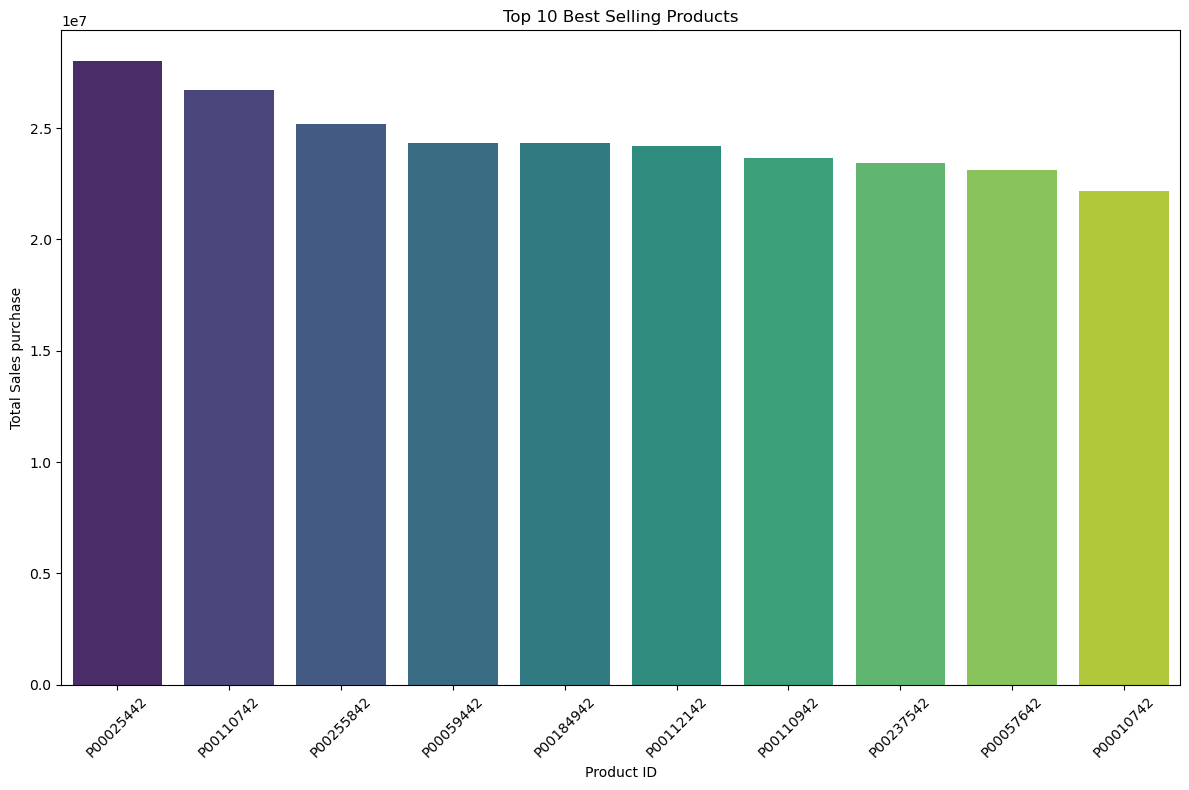

In [76]:
# Group the data by product_id and sum the purchase column
product_sales = df.groupby('product_id')['purchase'].sum()

# Sort the product sales in descending order and get the top 10
top_10_products = product_sales.sort_values(ascending=False).head(10)

# Plotting the top 10 best selling products
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_products.index, y=top_10_products.values, palette='viridis')
plt.title('Top 10 Best Selling Products')
plt.xlabel('Product ID')
plt.ylabel('Total Sales purchase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

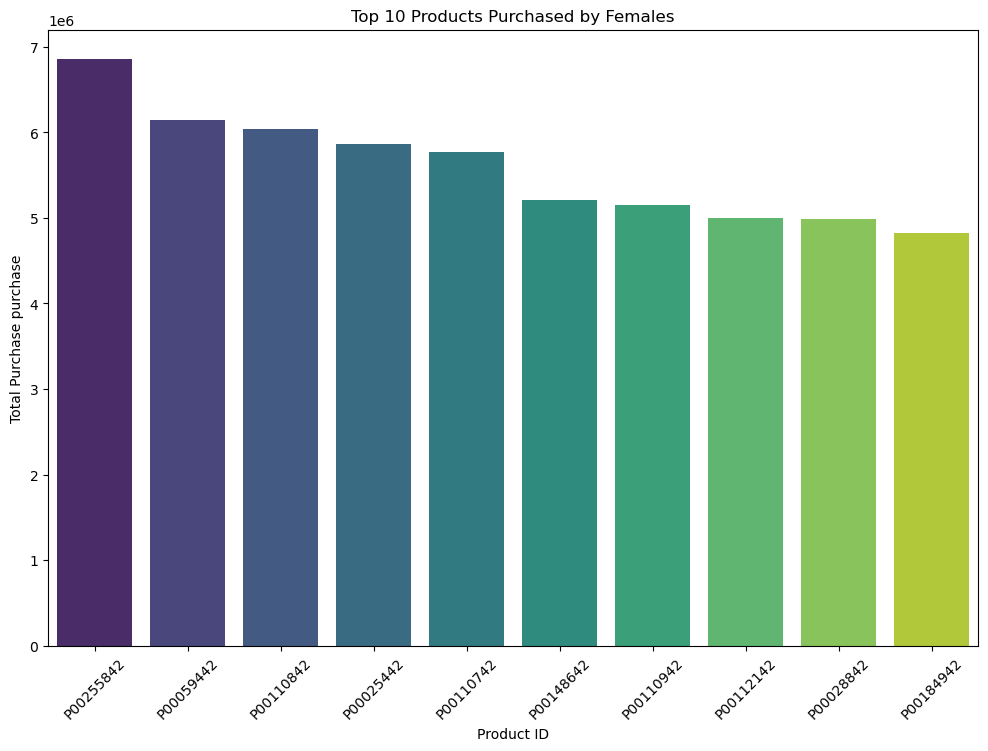

In [77]:
# Filter the dataset for female customers
female_data = df[df['gender'] == 'F']

# Group the data by product_id and sum the purchase purchases for females
female_product_sales = female_data.groupby('product_id')['purchase'].sum()

# Sort the product sales in descending order and get the top 10
top_10_female_products = female_product_sales.sort_values(ascending=False).head(10)

# Plotting the top 10 products purchased by females
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_female_products.index, y=top_10_female_products.values, palette='viridis')
plt.title('Top 10 Products Purchased by Females')
plt.xlabel('Product ID')
plt.ylabel('Total Purchase purchase')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

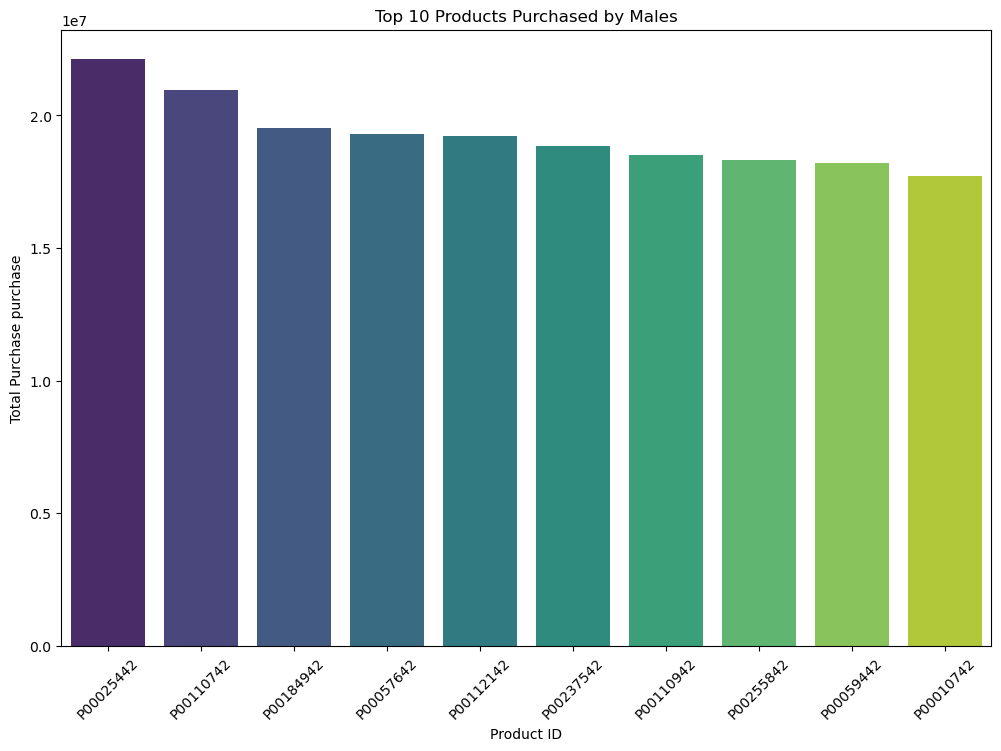

In [78]:
# Filter the dataset for male customers
male_data = df[df['gender'] == 'M']

# Group the data by product_id and sum the purchase purchases for males
male_product_sales = male_data.groupby('product_id')['purchase'].sum()

# Sort the product sales in descending order and get the top 10
top_10_male_products = male_product_sales.sort_values(ascending=False).head(10)

# Plotting the top 10 products purchased by males
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_male_products.index, y=top_10_male_products.values, palette='viridis')
plt.title('Top 10 Products Purchased by Males')
plt.xlabel('Product ID')
plt.ylabel('Total Purchase purchase')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

In [79]:
# Convert top 10 male and female product IDs into sets
male_top_10_set = set(top_10_male_products.index)
female_top_10_set = set(top_10_female_products.index)

# Find the intersection of these sets to identify products that are top 10 for both males and females
common_top_10_products = male_top_10_set.intersection(female_top_10_set)

# Output the common products
print("Common products in the top 10 lists for both males and females:")
print(common_top_10_products)

Common products in the top 10 lists for both males and females:
{'P00110742', 'P00025442', 'P00255842', 'P00112142', 'P00184942', 'P00110942', 'P00059442'}


In [80]:
df['product_id'].nunique()

3631

In [81]:
# Get the set of products bought by females
female_products = set(df[df['gender'] == 'F']['product_id'])

# Get the set of products bought by males
male_products = set(df[df['gender'] == 'M']['product_id'])

# Find the intersection of products bought by both genders
common_products = female_products.intersection(male_products)

# Count the number of products bought by both genders
common_product_count = len(common_products)

print(f"There are {common_product_count} products bought by both female and male customers.")

There are 3324 products bought by both female and male customers.


In [ ]:
3631 - 3324 # Only 307 products are bought by one gender

# Modeling

In this section, I began by splitting the data into training and testing sets, allocating 80% for training to model the purchasing behavior and 20% for evaluation to ensure robustness against unseen data. I chose a mix of demographic and categorical variables as features for the input and 'purchase' as the output variable. To correctly process categorical data, I converted the 'occupation' column to a string type, preparing it for one-hot encoding. I then set up a transformation pipeline using OneHotEncoder for nominal categories like 'city_category' and 'gender', and OrdinalEncoder for ordinal categories like 'age', specifying explicit ordering for each. I implemented these transformations to ensure that our model interprets the data accurately. After applying these transformations, I conducted an exploratory data analysis, calculating and visualizing the correlation matrix with a heatmap to identify influential predictors and check for multicollinearity. This thorough analysis and visualization help in presenting clear, data-driven insights and underscore the effectiveness of our preprocessing strategy in enhancing model performance.

In [83]:
X = df[['age', 'bmr', 'city_category',
       'gender', 'marital_status', 'occupation', 'stay_in_current_city_years',
       'category_1', 'category_10', 'category_11',
       'category_12', 'category_13', 'category_14', 'category_15',
       'category_16', 'category_17', 'category_18', 'category_19',
       'category_2', 'category_20', 'category_3', 'category_4', 'category_5',
       'category_6', 'category_7', 'category_8', 'category_9']]
y = df["purchase"]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<IPython.core.display.Javascript object>

In [85]:
cat_onehot = [
    "city_category",
    "gender",
    "occupation", 
]
cat_ordinal = [
    "age",
    "stay_in_current_city_years",
]

cat_for_age = ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
cat_for_stay_in_current_city_years = ['0', '1', '2', '3', '4+']

In [86]:
columns_to_convert = ['occupation']
for column in columns_to_convert:
    X_train[column] = X_train[column].astype(str)
    X_test[column] = X_test[column].astype(str)

In [87]:
column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_onehot),
    (
        OrdinalEncoder(
            categories=[cat_for_age, cat_for_stay_in_current_city_years]
        ),
        cat_ordinal,
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)  # MinMaxScaler()

column_trans = column_trans.set_output(transform="pandas")

In [88]:
X_train.head()

,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,category_1,category_10,category_11,...,category_19,category_2,category_20,category_3,category_4,category_5,category_6,category_7,category_8,category_9
401980,36-45,1650,B,F,0,20,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368189,26-35,2400,C,M,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
181444,26-35,1409,A,F,0,3,3,0,0,0,...,0,1,0,0,0,1,0,0,0,0
238822,18-25,2077,C,M,0,11,3,0,0,0,...,0,1,0,0,0,0,0,0,0,0
127422,26-35,1174,C,M,0,14,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
X_test.head()

,age,bmr,city_category,gender,marital_status,occupation,stay_in_current_city_years,category_1,category_10,category_11,...,category_19,category_2,category_20,category_3,category_4,category_5,category_6,category_7,category_8,category_9
41001,26-35,1503,B,M,0,17,3,1,0,0,...,0,0,0,0,0,1,1,0,0,0
16151,26-35,1488,B,M,0,12,4+,0,0,0,...,0,0,0,1,1,1,0,0,0,0
507262,26-35,1992,A,F,1,7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368698,36-45,2483,A,M,0,5,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
353782,26-35,1509,A,M,1,5,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [90]:
X_train.shape, X_test.shape

((440054, 27), (110014, 27))

In [ ]:
X_train_trans = column_trans.fit_transform(X_train)
X_test_trans = column_trans.transform(X_test)

In [106]:
X_train_trans.shape, X_test_trans.shape 

((440054, 50), (110014, 50))

In [107]:
X_train_trans.head()

,city_category_A,city_category_B,city_category_C,gender_F,gender_M,occupation_0,occupation_1,occupation_10,occupation_11,occupation_12,...,category_19,category_2,category_20,category_3,category_4,category_5,category_6,category_7,category_8,category_9
401980,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
368189,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
181444,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
238822,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
127422,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
X_test_trans.head()

,city_category_A,city_category_B,city_category_C,gender_F,gender_M,occupation_0,occupation_1,occupation_10,occupation_11,occupation_12,...,category_19,category_2,category_20,category_3,category_4,category_5,category_6,category_7,category_8,category_9
41001,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,0
16151,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,1,1,1,0,0,0,0
507262,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
368698,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
353782,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [109]:
X_train_trans.join(y_train).corr()

,city_category_A,city_category_B,city_category_C,gender_F,gender_M,occupation_0,occupation_1,occupation_10,occupation_11,occupation_12,...,category_2,category_20,category_3,category_4,category_5,category_6,category_7,category_8,category_9,value
city_category_A,1.000000,-0.516091,-0.407147,-0.006763,0.006763,0.002057,0.002079,-0.034408,-0.018016,-0.021961,...,-0.019673,-0.013841,-0.011086,-0.012548,0.009313,-0.001076,0.011889,0.012100,-0.011269,-0.042403
city_category_B,-0.516091,1.000000,-0.572201,0.006417,-0.006417,0.007050,-0.003084,-0.029760,0.019116,-0.000488,...,-0.001272,-0.015561,0.001187,0.010966,0.005664,-0.001697,0.001924,-0.004250,0.000186,-0.019459
city_category_C,-0.407147,-0.572201,1.000000,-0.000367,0.000367,-0.009488,0.001298,0.064679,-0.003134,0.021547,...,0.020193,0.029847,0.009349,0.000320,-0.014957,0.002840,-0.013434,-0.007054,0.010591,0.061349
gender_F,-0.006763,0.006417,-0.000367,1.000000,-1.000000,0.011167,0.095328,0.021003,-0.041284,-0.076526,...,-0.039197,0.005843,0.016614,0.032136,0.039703,-0.026793,0.000558,0.053729,-0.003737,-0.059886
gender_M,0.006763,-0.006417,0.000367,-1.000000,1.000000,-0.011167,-0.095328,-0.021003,0.041284,0.076526,...,0.039197,-0.005843,-0.016614,-0.032136,-0.039703,0.026793,-0.000558,-0.053729,0.003737,0.059886
occupation_0,0.002057,0.007050,-0.009488,0.011167,-0.011167,1.000000,-0.117212,-0.059323,-0.056197,-0.093428,...,-0.002817,-0.002629,0.001567,0.002250,0.000432,0.001161,0.005659,-0.005549,0.000446,-0.010012
occupation_1,0.002079,-0.003084,0.001298,0.095328,-0.095328,-0.117212,1.000000,-0.047849,-0.045328,-0.075358,...,-0.012574,-0.000494,-0.008578,-0.007519,-0.004157,-0.005255,0.003293,0.034722,-0.005354,-0.019129
occupation_10,-0.034408,-0.029760,0.064679,0.021003,-0.021003,-0.059323,-0.047849,1.000000,-0.022941,-0.038140,...,0.012945,0.003844,0.038011,0.056679,0.014691,-0.014019,-0.007119,-0.031388,0.011356,-0.008481
occupation_11,-0.018016,0.019116,-0.003134,-0.041284,0.041284,-0.056197,-0.045328,-0.022941,1.000000,-0.036130,...,-0.005903,0.002399,-0.006294,-0.007397,0.002963,0.004461,0.001625,0.008451,-0.004904,-0.001482
occupation_12,-0.021961,-0.000488,0.021547,-0.076526,0.076526,-0.093428,-0.075358,-0.038140,-0.036130,1.000000,...,0.016541,0.003288,0.004647,-0.005395,-0.005558,-0.002633,-0.003198,-0.016033,0.005765,0.025543


In [111]:
corr = X_train_trans.join(y_train).corr()
fig = px.imshow(corr, width=1000, height=1000)
fig.show()

## Modeling with Pipeline for XG Boost Regressor

In this section, I employed a predictive modeling using XGBoost integrated within a pipeline, which includes data preprocessing and regression modeling. Initially, I set up a pipeline combining an encoder for categorical variables and an XGBoost regressor. After training this pipeline on the data, I evaluated its performance using a custom function that calculates metrics such as R2, MAE, MSE, and RMSE for both training and testing datasets. To optimize the model, I implemented a grid search to fine-tune hyperparameters like the number of estimators. Furthermore, I conducted a feature importance analysis to identify which features most influence purchase predictions, utilizing this insight to refine the model further. Also I employed baseline linear regression model.

In [91]:
def train_val(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    scores = {
        "train": {
            "R2": r2_score(y_train, y_train_pred),
            "mae": mean_absolute_error(y_train, y_train_pred),
            "mse": mean_squared_error(y_train, y_train_pred, squared=True),
            "rmse": mean_squared_error(y_train, y_train_pred, squared=False),
        },
        "test": {
            "R2": r2_score(y_test, y_pred),
            "mae": mean_absolute_error(y_test, y_pred),
            "mse": mean_squared_error(y_test, y_pred, squared=True),
            "rmse": mean_squared_error(y_test, y_pred, squared=False),
        },
    }

    return pd.DataFrame(scores)

In [ ]:
operations = [
    ("Encoder", column_trans),
    ("XGB_model", XGBRegressor(random_state=101)),
]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)


In [113]:
train_val(pipe_model, X_train, y_train, X_test, y_test)

,train,test
R2,6.824837e-01,6.756548e-01
mae,2.113988e+03,2.135591e+03
mse,8.007124e+06,8.200589e+06
rmse,2.829686e+03,2.863667e+03


In [ ]:
operations = [
    ("Encoder", column_trans),
    ("XGB_model", XGBRegressor(random_state=101)),
]

model = Pipeline(steps=operations)

scores = cross_validate(
    model,
    X_train,
    y_train,
    scoring=[
        "r2",
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
    ],
    cv=10,
    return_train_score=True,
)
pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                              6.749521e-01
train_r2                             6.830507e-01
test_neg_mean_absolute_error        -2.138162e+03
train_neg_mean_absolute_error       -2.113321e+03
test_neg_mean_squared_error         -8.196830e+06
train_neg_mean_squared_error        -7.992821e+06
test_neg_root_mean_squared_error    -2.862989e+03
train_neg_root_mean_squared_error   -2.827155e+03
dtype: float64

## Gridsearch for XGBoost

In [94]:
param_grid = {
    "XGB_model__n_estimators": [30, 35],
    "XGB_model__max_depth": [2, 3],
    "XGB_model__learning_rate": [0.055, 0.06],
    "XGB_model__subsample": [0.5, 0.8],
    "XGB_model__colsample_bytree": [0.5, 0.8, 1],
    "XGB_model__colsample_bylevel": [0.5, 0.8, 1],
}

In [95]:
operations = [
    ("Encoder", column_trans),
    ("XGB_model", XGBRegressor(random_state=101)),
]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=10,
    n_jobs=-1,
    return_train_score=True,
)

<IPython.core.display.Javascript object>

In [ ]:
grid_model.fit(X_train, y_train)

In [98]:
grid_model.best_estimator_

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['city_category', 'gender',
                                                   'occupation']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['0-17',
                                                                              '18-25',
                                                                              '26-35',
                                                                              '36-45',
                                                                              '46-50',
                                                                              '51-55',
                                                                              '55+'],
                                                                             ['0',
                                                                              '1',
                                                                              '2',
                                                                              '3',
                                                                              '4+']]),
                                                  ['age',
                                                   'stay_in_current_city_yea...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.06,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=35,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=101, ...))])

In [99]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,4.279874e-01,4.264560e-01
mae,2.900705e+03,2.907765e+03
mse,1.442501e+07,1.450121e+07
rmse,3.798027e+03,3.808045e+03


## Feature importance

In [ ]:
operations = [
    ("Encoder", column_trans),
    (
        "XGB_model",
        XGBRegressor(
            n_estimators=35,
            learning_rate=0.06,
            max_depth=3,
            subsample=0.5,
            random_state=101,
        ),
    ),
]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

In [101]:
features = pipe_model["Encoder"].get_feature_names_out()
features

array(['city_category_A', 'city_category_B', 'city_category_C',
       'gender_F', 'gender_M', 'occupation_0', 'occupation_1',
       'occupation_10', 'occupation_11', 'occupation_12', 'occupation_13',
       'occupation_14', 'occupation_15', 'occupation_16', 'occupation_17',
       'occupation_18', 'occupation_19', 'occupation_2', 'occupation_20',
       'occupation_3', 'occupation_4', 'occupation_5', 'occupation_6',
       'occupation_7', 'occupation_8', 'occupation_9', 'age',
       'stay_in_current_city_years', 'bmr', 'marital_status',
       'category_1', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16',
       'category_17', 'category_18', 'category_19', 'category_2',
       'category_20', 'category_3', 'category_4', 'category_5',
       'category_6', 'category_7', 'category_8', 'category_9'],
      dtype=object)

In [102]:
pipe_model["XGB_model"].feature_importances_

array([2.3130614e-03, 0.0000000e+00, 5.0126412e-03, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 8.0649997e-04, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 6.5727159e-04, 0.0000000e+00,
       3.1591690e-04, 0.0000000e+00, 3.3209869e-01, 1.2391530e-01,
       6.7223474e-02, 0.0000000e+00, 3.3233427e-02, 2.6277327e-03,
       1.2252476e-03, 1.6168542e-02, 2.7904443e-03, 0.0000000e+00,
       3.8112380e-02, 4.3889508e-02, 4.8926394e-02, 2.1641271e-02,
       4.2333356e-03, 6.8540104e-02, 1.2284618e-01, 5.8992114e-02,
       4.4305199e-03, 0.0000000e+00], dtype=float32)

In [104]:
imp_feats = pd.DataFrame(
    data=pipe_model["XGB_model"].feature_importances_,
    columns=["xgb_Importance"],
    index=features,
)

xgb_imp_feats = imp_feats.sort_values("xgb_Importance", ascending=False)
xgb_imp_feats

,xgb_Importance
category_1,0.332099
category_10,0.123915
category_6,0.122846
category_5,0.068540
category_11,0.067223
category_7,0.058992
category_20,0.048926
category_2,0.043890
category_19,0.038112
category_13,0.033233


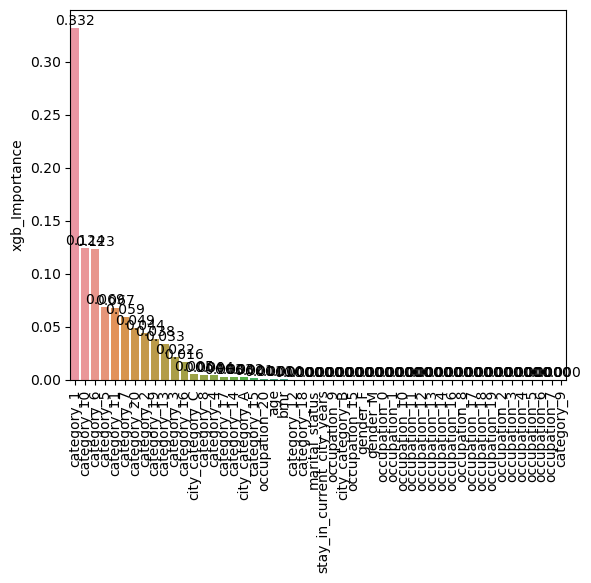

In [105]:
ax = sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y="xgb_Importance")

ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

In [ ]:
from sklearn.linear_model import LinearRegression

operations = [
    ("Encoder", column_trans),
    ("LinearReg", LinearRegression())
]

lr_model = Pipeline(steps=operations)

lr_model.fit(X_train, y_train)


In [110]:
train_val(lr_model, X_train, y_train, X_test, y_test)

,train,test
R2,4.805555e-01,4.785917e-01
mae,2.729553e+03,2.741438e+03
mse,1.309935e+07,1.318304e+07
rmse,3.619302e+03,3.630845e+03


In [ ]:
operations = [
    ("Encoder", column_trans),
    ("LinearReg", LinearRegression()),
]

lr_model_cv = Pipeline(steps=operations)

scores = cross_validate(
    lr_model_cv,
    X_train,
    y_train,
    scoring=[
        "r2",
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
    ],
    cv=10,
    return_train_score=True,
)
pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                              4.804012e-01
train_r2                             4.805631e-01
test_neg_mean_absolute_error        -2.729939e+03
train_neg_mean_absolute_error       -2.729533e+03
test_neg_mean_squared_error         -1.310305e+07
train_neg_mean_squared_error        -1.309915e+07
test_neg_root_mean_squared_error    -3.619801e+03
train_neg_root_mean_squared_error   -3.619275e+03
dtype: float64